# Analyse en composantes principales

L'analyse en composantes principales (ACP) est une méthode statistique pour transformer un ensemble de $p$ variables potentiellement corrélées entre elles en un ensemble de $p$ variables sans corrélations linéaires (à condition d'avoir au moins $p$ observations). Ces dernières variables sont appelées les **composantes principales**. Cette transformation est faite en sorte que la première composante principale capte la plus grande part de la variance. Cette propriété fait que nous pouvons généralement ne tenir compte que des premières composantes principales et abandonner les autres, sans grande perte d'information. En conséquence, l'ACP est une technique de **réduction de la dimensionalité** (une dimension est équivalente à une variable en statistique), ou encore une méthode du **feature extraction** (un *feature* étant une variable).

Une ACP est typiquement faite dans le cadre d'une analyse exploratoire où on essaie de regarder quelles sont les dimensions intrinsèques d'un système d'indicateur. Ces dimensions seront exprimées sous forme de facteurs (ou des composantes principales pour être précis) que nous pourrons aussi cartographier. L'enjeu d'une telle analyse est de simplifier une grande quantité de données en essayant de garder un maximum d'informations.

## 1. Préparation du jeu de données

La préparation des données implique la sélection de variables et le calcul des indicateurs. Nous pouvons par exemple nous interroger sur la structure spatiale de la pendularité, et ainsi collecter des variables relatives à la pendularité, et en plus des variables qui pourraient expliquer le comportement de mobilité quotidienne.

Une fois qu'un premier ensemble de variables a été défini, nous devons nous assurer que ces variables peuvent fonctionner comme indicateurs, c'est-à-dire sont relatives à la structure et non l'ampleur d'un phénomène. Ceci implique typiquement le calcul de pourcentages.

Le jeu d'indicateurs définitif sera développé au cours de l'analyse. Nous pouvons commencer dans R comme d'habitude avec le chargement les données:

In [30]:
d = read.csv(file="zh-acp-mobilite.tsv", sep="\t")

Et nous pouvons afficher le premières lignes du tableau pour vérification:

In [31]:
head(d, 3)

Z05,NAME,PTOT,NON_PEND,INTRA_COM_PEND,INTER_COM_PEND,PEND_MD,PEND_AUTO,PEND_TP,AGE_0_19,⋯,REV_150K_PLUS,BATI_BAS,BATI_HAUT,FOY_1_PERS,FOY_COUPLES,FOY_ENF,FOY_GRANDS_ENF,FOY_MONO_ENF,FOY_MULTI,FOY_COLOC
1.0,Reppischtal,5214,0.08819346,0.0682788,0.8435277,0.01373980,0.6363246,0.3499356,0.2332183,⋯,0.06069854,0.8816442,0.1183558,0.2805722,0.3174896,0.3041071,0.02399631,0.05906784,0.005076142,0.02168897
2.1,Affoltern am Albis Zentrum,7295,0.03354298,0.2348008,0.7316562,0.08829282,0.4786253,0.4330819,0.2032899,⋯,0.01718427,0.7845912,0.2154088,0.3580201,0.2989928,0.2361094,0.03322142,0.04508621,0.008305355,0.01690733
2.2,Affoltern am Albis-Zwillikon Hedingen,6666,0.07382185,0.1190411,0.8071370,0.03348214,0.5360332,0.4304847,0.2412241,⋯,0.03502674,0.8898590,0.1101410,0.3359182,0.2883327,0.2876278,0.02855129,0.05216778,0.002819880,0.01797674


Vérifier le nombre de colonnes:

In [32]:
ncol(d)

[1] 33

et extraire toutes les variables numériques que nous utiliserons dans l'ACP (colonnes 4 à 33). Nous ne prenons pas en compte la population totale, elle est là uniquement pour information et éventuellement pour pouvoir pondérer les différentes unités spatiales.

In [35]:
d_acp = d[,4:33]

In [36]:
head(d_acp, 3)

NON_PEND,INTRA_COM_PEND,INTER_COM_PEND,PEND_MD,PEND_AUTO,PEND_TP,AGE_0_19,AGE_20_39,AGE_40_64,AGE_65_PLUS,⋯,REV_150K_PLUS,BATI_BAS,BATI_HAUT,FOY_1_PERS,FOY_COUPLES,FOY_ENF,FOY_GRANDS_ENF,FOY_MONO_ENF,FOY_MULTI,FOY_COLOC
0.08819346,0.0682788,0.8435277,0.01373980,0.6363246,0.3499356,0.2332183,0.2169160,0.4115842,0.1382816,⋯,0.06069854,0.8816442,0.1183558,0.2805722,0.3174896,0.3041071,0.02399631,0.05906784,0.005076142,0.02168897
0.03354298,0.2348008,0.7316562,0.08829282,0.4786253,0.4330819,0.2032899,0.2677176,0.3834133,0.1455792,⋯,0.01718427,0.7845912,0.2154088,0.3580201,0.2989928,0.2361094,0.03322142,0.04508621,0.008305355,0.01690733
0.07382185,0.1190411,0.8071370,0.03348214,0.5360332,0.4304847,0.2412241,0.2295230,0.3922892,0.1369637,⋯,0.03502674,0.8898590,0.1101410,0.3359182,0.2883327,0.2876278,0.02855129,0.05216778,0.002819880,0.01797674


## 2. Vérifier si une ACP est appropriée

Un jeu de données se prête bien à une ACP si plusieurs variables sont corrélées entre elles, c'est-à-dire représentent la même information. Dans ce cas, l'ACP permet de sortir les composantes uniques et ainsi réduire l'information.

En conséquence, ce ne sont donc pas tous les jeux de données qui se prêtent automatiquement à une ACP. On peut sans problème calculer l'ACP, mais le résultat ne sera pas convaincant et l'interprétation difficile voire impossible. Nous devons donc commencer par évaluer si notre jeu de données se prête à une ACP. Pour cela, nous montrons ici 3 approches possibles:

1. L'observation de la **matrice des corrélations**. Si plusieurs variables sont corrélées à plus de 0.5, c'est possible. Sinon, ce sera une opération difficile à priori.

2. Vérifier **l'indice de KMO**, qui doit être entre 0.5 et 1 pour procéder à une ACP.

3. On fait le **test de sphéricité de Bartlett** qui vérifie que les variables ne sont pas issues d'une population dont la matrice est l'identité.

### 2.1 La matrice des corrélations

La **matrice des corrélations** peut s'afficher simplement comme suit:

In [38]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
cor(d_acp)

,NON_PEND,INTRA_COM_PEND,INTER_COM_PEND,PEND_MD,PEND_AUTO,PEND_TP,AGE_0_19,AGE_20_39,AGE_40_64,AGE_65_PLUS,EDU_PRE,EDU_BAS,EDU_MOY,EDU_HAUT,SECT_PRI,SECT_SEC,SECT_TER,REV_0_40K,REV_40K_80K,REV_80K_150K,REV_150K_PLUS,BATI_BAS,BATI_HAUT,FOY_1_PERS,FOY_COUPLES,FOY_ENF,FOY_GRANDS_ENF,FOY_MONO_ENF,FOY_MULTI,FOY_COLOC
NON_PEND,1.00000000,-0.417218576,0.335565788,-0.18339550,0.420525542,-0.43163443,0.27805356,-0.54118884,0.673931920,0.076816473,0.19942128,-0.480884256,0.26893478,0.06410282,0.58646032,0.04877408,-0.17026645,-0.128919683,-0.42459149,0.265322107,0.332976339,0.43952280,-0.43952280,-0.35643060,0.40107095,0.337518258,0.120738943,-0.089298300,-0.20413881,-0.35544425
INTRA_COM_PEND,-0.41721858,1.000000000,-0.996114939,0.52031203,-0.862153792,0.85019077,-0.57983837,0.62003055,-0.594981920,-0.008538256,-0.48427026,0.038226555,-0.70540081,0.58092383,-0.44377879,-0.56144670,0.59606969,0.240791527,0.32793117,-0.364900697,-0.179411998,-0.91606300,0.91606300,0.80767486,-0.78777088,-0.702306226,-0.517950185,-0.147203732,-0.24670370,0.53546595
INTER_COM_PEND,0.33556579,-0.996114939,1.000000000,-0.52155496,0.852910960,-0.83943433,0.57408428,-0.59024760,0.551420909,0.001406812,0.48264323,0.006973852,0.70511876,-0.60836411,0.40316828,0.57723753,-0.60135324,-0.237098577,-0.29877220,0.352525788,0.153703112,0.90694936,-0.90694936,-0.80265195,0.77769500,0.695265411,0.525178181,0.161235952,0.27549992,-0.52059126
PEND_MD,-0.18339550,0.520312026,-0.521554958,1.00000000,-0.620537165,0.46136384,-0.50556240,0.57630377,-0.367658716,-0.203975856,-0.49554060,-0.021156462,-0.47505568,0.46446502,-0.31948568,-0.30169218,0.33781772,0.298394034,0.24781588,-0.345900969,-0.181852727,-0.41766528,0.41766528,0.58730464,-0.53423870,-0.594262956,-0.388322618,-0.229212210,-0.12835801,0.56015684
PEND_AUTO,0.42052554,-0.862153792,0.852910960,-0.62053717,1.000000000,-0.98202392,0.69106377,-0.70570975,0.635020126,0.019112052,0.58328286,0.028369854,0.82055473,-0.72616506,0.59127832,0.72362082,-0.77242128,-0.389552716,-0.13595227,0.374198085,-0.001042946,0.87440369,-0.87440369,-0.88367035,0.81650068,0.815618925,0.610403730,0.212390765,0.27340584,-0.65557781
PEND_TP,-0.43163443,0.850190773,-0.839434332,0.46136384,-0.982023925,1.00000000,-0.66017135,0.65971378,-0.629958373,0.027475100,-0.54064129,-0.027004908,-0.81401946,0.70977705,-0.59206484,-0.74607899,0.79259575,0.368911153,0.09416432,-0.340103832,0.044953108,-0.88875794,0.88875794,0.85840886,-0.79518700,-0.779741164,-0.597133664,-0.185124187,-0.27843237,0.60688161
AGE_0_19,0.27805356,-0.579838366,0.574084280,-0.50556240,0.691063773,-0.66017135,1.00000000,-0.63977375,0.394531491,-0.160673220,0.94656719,0.078958580,0.48776114,-0.62644815,0.52059703,0.54881761,-0.60143233,-0.326918191,-0.07444234,0.326618510,-0.032261358,0.63528479,-0.63528479,-0.82837285,0.52204391,0.920587012,0.501417421,0.482130362,0.21451341,-0.56470795
AGE_20_39,-0.54118884,0.620030548,-0.590247597,0.57630377,-0.705709754,0.65971378,-0.63977375,1.00000000,-0.724240310,-0.492939926,-0.53607975,0.234277724,-0.61183447,0.40926262,-0.48121227,-0.30652974,0.37709993,0.314490902,0.41159942,-0.417495112,-0.292221622,-0.68454143,0.68454143,0.69486903,-0.68747124,-0.694938150,-0.452154864,-0.214301151,0.06874638,0.77563958
AGE_40_64,0.67393192,-0.594981920,0.551420909,-0.36765872,0.635020126,-0.62995837,0.39453149,-0.72424031,1.000000000,-0.005300576,0.26910709,-0.402221624,0.52699989,-0.17793130,0.55531589,0.20451767,-0.30225854,-0.283779050,-0.40226734,0.462168184,0.223033589,0.61428418,-0.61428418,-0.56636256,0.57814895,0.543495857,0.364835623,-0.017903744,-0.05701843,-0.49414878
AGE_65_PLUS,0.07681647,-0.008538256,0.001406812,-0.20397586,0.019112052,0.02747510,-0.16067322,-0.49293993,-0.005300576,1.000000000,-0.17855909,-0.115910452,0.13897027,0.02418750,-0.14120264,-0.15424977,0.16793135,0.009437909,-0.28169063,0.008823374,0.333358649,0.05194397,-0.05194397,0.06315631,0.19233733,-0.126519066,-0.003564487,-0.053638926,-0.26266605,-0.38044503


On remarque qu'il y a un bon nombre de corrélations avec des valeurs plus élevées que 0.5 (considérer la valeur absolu). Mais il y a aussi d'autres variables qui sont uniquement faiblement corrélées avec les autres. Avec une petit calcul dans R on peut faire sortir les valeurs maximum et minimum des corrélations par colonne (en éliminant la corrélation 1.0 de la diagonale):

In [48]:
cor_mat = cor(d_acp)
cor_mat[cor_mat == 1.0] = 0
apply(cor_mat, 1, range)

NON_PEND,INTRA_COM_PEND,INTER_COM_PEND,PEND_MD,PEND_AUTO,PEND_TP,AGE_0_19,AGE_20_39,AGE_40_64,AGE_65_PLUS,EDU_PRE,EDU_BAS,EDU_MOY,EDU_HAUT,SECT_PRI,SECT_SEC,SECT_TER,REV_0_40K,REV_40K_80K,REV_80K_150K,REV_150K_PLUS,BATI_BAS,BATI_HAUT,FOY_1_PERS,FOY_COUPLES,FOY_ENF,FOY_GRANDS_ENF,FOY_MONO_ENF,FOY_MULTI,FOY_COLOC
-0.5411888,-0.9961149,-0.9961149,-0.6205372,-0.9820239,-0.9820239,-0.8283728,-0.7242403,-0.7242403,-0.4929399,-0.7489516,-0.5784270,-0.8140195,-0.8303312,-0.5920648,-0.9804512,-0.9804512,-0.4216463,-0.7190585,-0.4216064,-0.7190585,-1.0000000,-1.000000,-0.9257099,-0.8604426,-0.9257099,-0.6158063,-0.3835649,-0.4293893,-0.6555778
0.6739319,0.9160630,0.9069494,0.5873046,0.8744037,0.8887579,0.9465672,0.7756396,0.6739319,0.3333586,0.9465672,0.4968113,0.8205547,0.8137853,0.5912783,0.7236208,0.8137853,0.4153237,0.4968113,0.4621682,0.3631389,0.9069494,0.916063,0.8584089,0.8165007,0.9205870,0.6104037,0.4821304,0.4916727,0.7756396


### 2.2 L'indice de KMO

L'indice de Kaiser-Meyer-Olkin (KMO) est une mesure pour savoir si une ACP donnera un bon résultat ou non. Il prend une valeur de 1 si aucune variable est seule sans corrélation aux autres (ce qui est une situation favorable pour une ACP). Les auteurs de l'indice proposent l'échelle suivante pour savoir si on peut procéder à une ACP:

    - < 0.5: inacceptable, on renonce à l'ACP
    - 0.5 - 0.6: c'est médiocre
    - 0.6 - 0.7: c'est moyen
    - 0.7 ou plus: entre bien et excellent, une ACP donnera des résultats intéressants

Certains chercheurs préfèrent mettre le seuil plutôt à 0.6 au lieu de 0.5. À vous de juger lequel vous voulez adopter...

Dans R, L'indice de KMO peut se calculer avec la fonction __`KMO`__ du package R [psych](https://cran.r-project.org/web/packages/psych/). Nous chargeons d'abord le package:

In [60]:
library(psych)

et s'il manque, nous l'installons d'abord avec:

In [ ]:
install.packages(c('psych'))

et finalement le calcul de l'indice KMO:

In [61]:
KMO(d_acp)

matrix is not invertible, image not found


Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = d_acp)
Overall MSA =  0.5
MSA for each item = 
      NON_PEND INTRA_COM_PEND INTER_COM_PEND        PEND_MD      PEND_AUTO 
           0.5            0.5            0.5            0.5            0.5 
       PEND_TP       AGE_0_19      AGE_20_39      AGE_40_64    AGE_65_PLUS 
           0.5            0.5            0.5            0.5            0.5 
       EDU_PRE        EDU_BAS        EDU_MOY       EDU_HAUT       SECT_PRI 
           0.5            0.5            0.5            0.5            0.5 
      SECT_SEC       SECT_TER      REV_0_40K    REV_40K_80K   REV_80K_150K 
           0.5            0.5            0.5            0.5            0.5 
 REV_150K_PLUS       BATI_BAS      BATI_HAUT     FOY_1_PERS    FOY_COUPLES 
           0.5            0.5            0.5            0.5            0.5 
       FOY_ENF FOY_GRANDS_ENF   FOY_MONO_ENF      FOY_MULTI      FOY_COLOC 
           0.5            0.5            0.5            0.5         

ce qui nous donne un mauvais présentiment pour notre ACP...

### 2.3 Le test de sphéricité de Bartlett

Le test de sphéricité de Bartlett teste si la matrice de corrélation est une matrice identité, ce qui veut dire que les variables ne sont pas corrélées aux autres et que les composantes principales seront équivalentes aux variables.

$H_0$: correlation matrix is identity matrix  
$H_1$: correlation matrix is not identity matrix

Nous utilisons cette fois le package R [REdaS](https://cran.r-project.org/web/packages/REdaS/), avec la fonction __`bart_spher`__.

In [65]:
library(REdaS)

Si nécessaire l'installer avec:

In [ ]:
install.packages(c('REdaS'))

Et finalement caculer le test:

In [64]:
bart_spher(d_acp)

	Bartlett's Test of Sphericity

Call: bart_spher(x = d_acp)

     X2 = 62744.853
     df = 435
p-value < 2.22e-16

Avec un p-value de 0, on peut rejeter $H_0$ et cette fois nous sommes contents car une ACP semble être possible avec un tel résultat.

## 3. Calcul de l'ACP

Plusieurs fonctions existents dans R pour effectuer une ACP. Ici, nous utilisons la fonction **PCA** du package __[FactoMineR](https://cran.r-project.org/web/packages/FactoMineR/)__:

In [94]:
library(FactoMineR)

ou l'installer si nécessaire:

In [ ]:
install.packages(c('FactoMineR'))

Nous allons égalmenet utiliser le package __[factoextra](https://github.com/kassambara/factoextra)__:

In [ ]:
install.packages(c("factoextra", "ggpubr"))

In [175]:
library("factoextra")

In [98]:
acp = PCA(d_acp, scale.unit=TRUE, ncp=5, graph=TRUE)

Le paramètre `ncp` définit le nombre de dimensions à garder dans les résultats.

Il est important à noter que l'ACP est sensible aux valeurs des données. Afin d'éviter des problèmes, il est important de standardiser les valeurs, ce qui est fait avec l'option `scale.unit=TRUE`.

Nous pouvons afficher un premier résultat de l'ACP:

In [ ]:
get_eig(acp)

ou si nous voulons nous limiter aux premières 10 composantes:

In [179]:
get_eig(acp)[1:10,]

,eigenvalue,variance.percent,cumulative.variance.percent
Dim.1,14.2553931,47.517977,47.51798
Dim.2,4.2762238,14.254079,61.77206
Dim.3,1.7820041,5.940014,67.71207
Dim.4,1.7462430,5.820810,73.53288
Dim.5,1.4528772,4.842924,78.37580
Dim.6,1.1505670,3.835223,82.21103
Dim.7,0.8001090,2.667030,84.87806
Dim.8,0.6587434,2.195811,87.07387
Dim.9,0.6123215,2.041072,89.11494
Dim.10,0.5413911,1.804637,90.91958


Les valeurs propres sont données dans la colonne de gauche. La proportion de variance expliquée montre l'importance de la composante (la proportion de l'information capturée). La proportion cumulée de la variance expliquée fait la somme de la variance expliquée de toutes les composantes qui sont plus importantes.

__Pour avoir une bonne ACP, il faut généralement viser une première composante qui explique au moins 50% de la variance, et les quatre premières composantes arrivent à 85% de variance expliquée.__

Pour arriver à une meilleure ACP, il faut jouer avec les indicateurs à inclure dans l'ACP, en enlevant certains qui sont trop indépendants (qui ont une faible corrélation avec d'autres variables), ou qui sont mal repris par les composantes.

Il se pose également la question combien de composantes nous voudrons garder. Un critère est de garder les composantes avec une valeur propre de 1 ou plus (c'est-à-dire 6 dans notre cas). Nous pouvons également faire un graphique de type **scree plot** avec la variance expliquée et ne garder que les composantes jusqu'au coude:

In [ ]:
plot(acp$eig[1:6,2], type="o", xlab="Composante", ylab="% variance expliquée")

ou plus joli, avec le package factoextra:

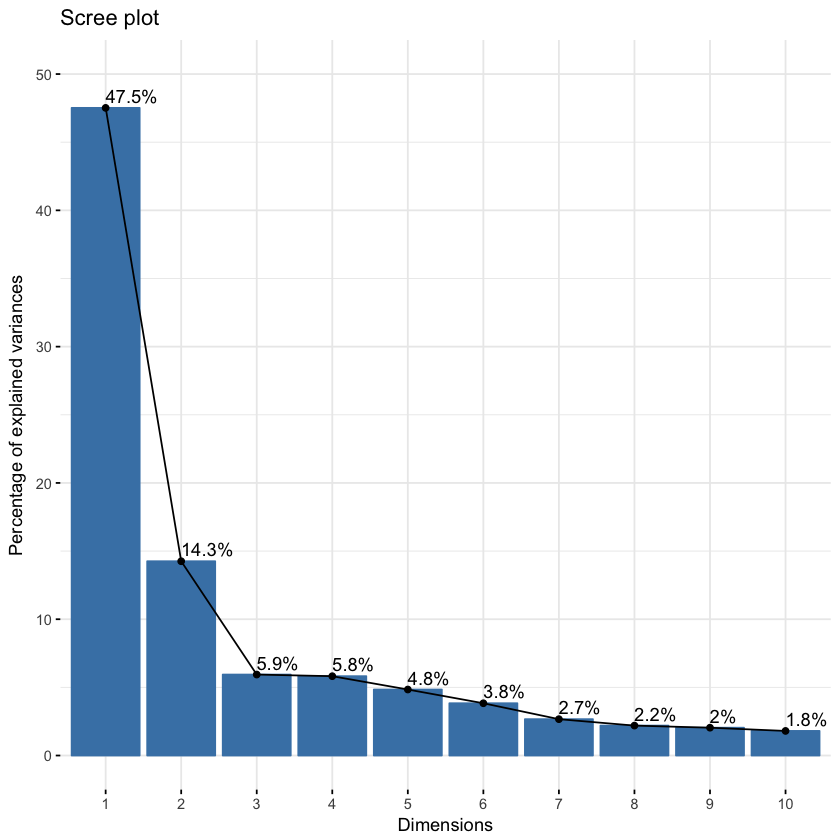

In [176]:
fviz_screeplot(acp, addlabels = TRUE, ylim = c(0, 50))

On garderait alors 3 composantes dans ce cas, contre 6 avec le critère des valeurs propres. On rencontre aussi parfois le critère que l'ensemble des composantes retenues doivent expliquer 80% de la variance, ce qui nous ferait garder également 6 composantes. Concrètement, il faut constater que notre ACP n'est pas encore idéale, et qu'il faudrait encore essayer d'éliminer de manière ciblée quelques indicateurs au départ (voir plus loin).

### 3.1 Les scores factoriels

Les scores factoriels déterminent le lien entre les régions analysées et les composantes principales.

Nous pouvons afficher un graphique des régions en fonction des composantes (ici les deux premières):

In [ ]:
plot.PCA(
    acp, 
    axes=c(1,2), 
    title="Scores factoriels des deux premières composantes",
    label="none",
    col.ind="blue"
)

ou encore, avec la couleur qui indique la qualité de chaque région par rapport à la dimension:

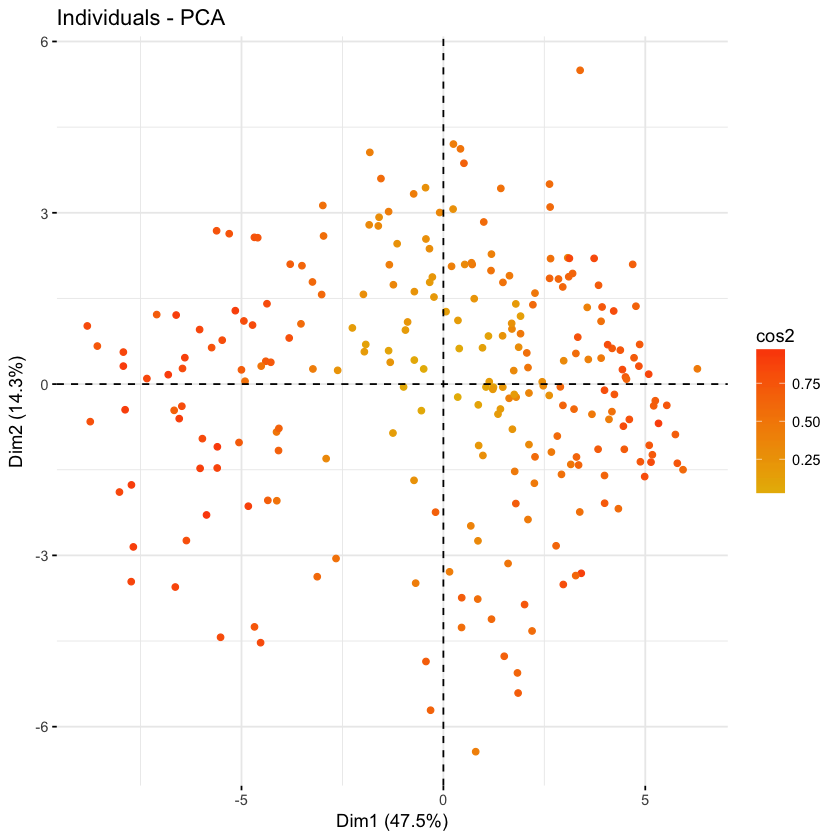

In [193]:
fviz_pca_ind(
    acp,
    col.ind="cos2", 
    gradient.cols=c("#E7B800", "#FC4E07"),
    geom="point"
)

Un tel graphique pourrait être retravaillé et interprété pour donner quelque chose d'un peu mieux:

![](figures/sotomo-factorscape.png)

Cet exemple de [SOTOMO](http://www.sotomo.ch) est très élaboré avec le calcul d'une surface de densités de noyaux sur la base de la population (relief ombré), la catégorisation et des labels élaborés. Mais en fait il s'agit ici de la cartographie, où les scores factoriels des deux premières composantes sont les coordonnées des points auquels on peut associer un poids (la population p.ex.) et faire une cartographie en symboles proportionnels.

Les scores factoriels en tant que tel peuvent être affichés avec:

In [ ]:
acp$ind$coord

et ce tableau peut être exporté avec:

In [148]:
write.csv(acp$ind$coord, file="~/Desktop/scores-factoriels.csv")

ce qui rend un traitement dans un logiciel de cartographie (p.ex. QGIS et puis Illustrator) possible.

### 3.2 Communalités

Les communalités permettent de définir la contribution des différentes variables aux composantes principales. Ainsi nous pouvons afficher un graphique qui montre la part des variables à deux composantes de notre choix (ici les deux premières composantes):

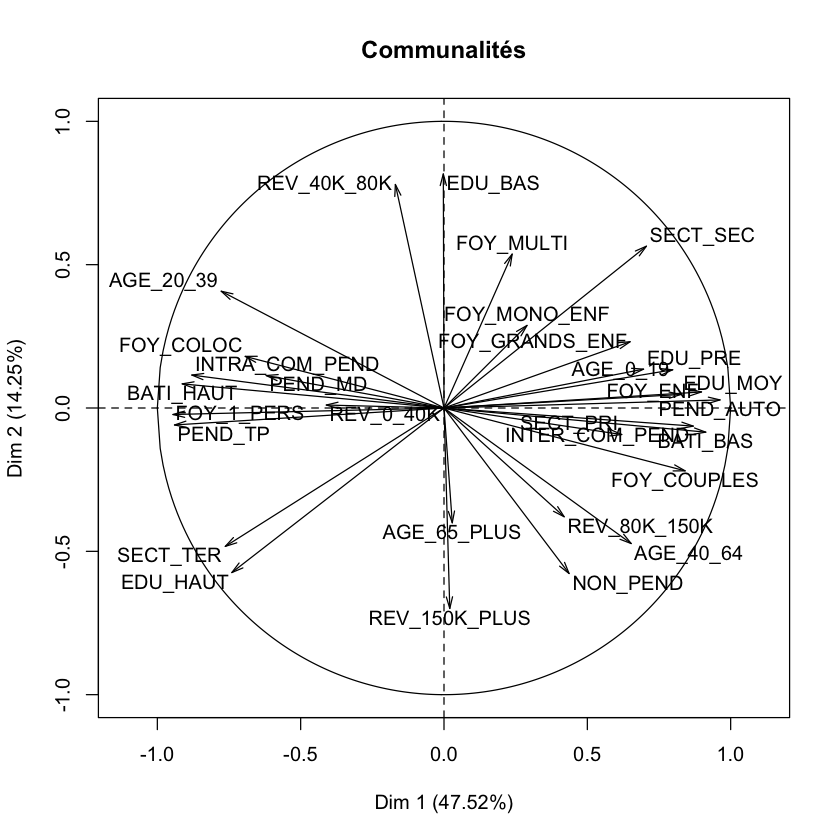

In [182]:
plot.PCA(acp, axes=c(1,2), choix="var", title="Communalités")

ou avec un peu de couleur pour indiquer la contribution de chaque variable:

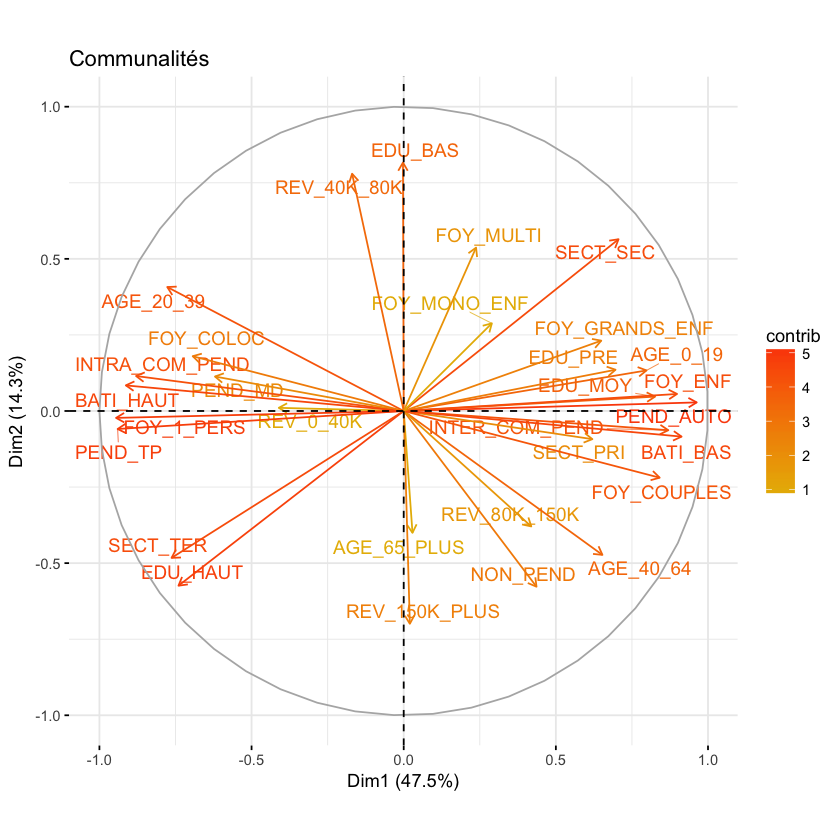

In [187]:
fviz_pca_var(
    acp, 
    col.var="contrib",
    gradient.cols=c("#E7B800", "#FC4E07"),
    repel=TRUE,    # Éviter la superposition de labels
    title="Communalités",
    axes=c(1,2)
)

Les communalités brutes peuvent aussi être affichées avec:

In [159]:
acp$var$cor

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
NON_PEND,0.436362106,-0.57743238,0.15636009,-0.26835848,0.139971923
INTRA_COM_PEND,-0.879624421,0.11493397,0.25198814,0.14591681,-0.150933743
INTER_COM_PEND,0.869485468,-0.06318125,-0.27634774,-0.12524533,0.142886156
PEND_MD,-0.620230092,0.11326844,0.05707180,-0.39948694,0.112727432
PEND_AUTO,0.962903164,0.02822292,-0.06629841,-0.10116392,-0.039961975
PEND_TP,-0.940126804,-0.05919562,0.06127188,0.21061506,0.018078406
AGE_0_19,0.797795347,0.13333021,0.29241844,0.35755244,0.257530198
AGE_20_39,-0.777092044,0.40737460,0.04416875,-0.26222965,0.212984831
AGE_40_64,0.653036783,-0.47286485,0.12265498,-0.24366004,0.044410041
AGE_65_PLUS,0.028830953,-0.40040021,-0.45180413,0.34404276,-0.640897566


Il s'agit en fait de la corrélation entre les variables et les composantes, ce qui est important pour l'interprétation des différentes dimensions.

On peut aussi faire un graphique des contributions des différentes variables aux composantes:

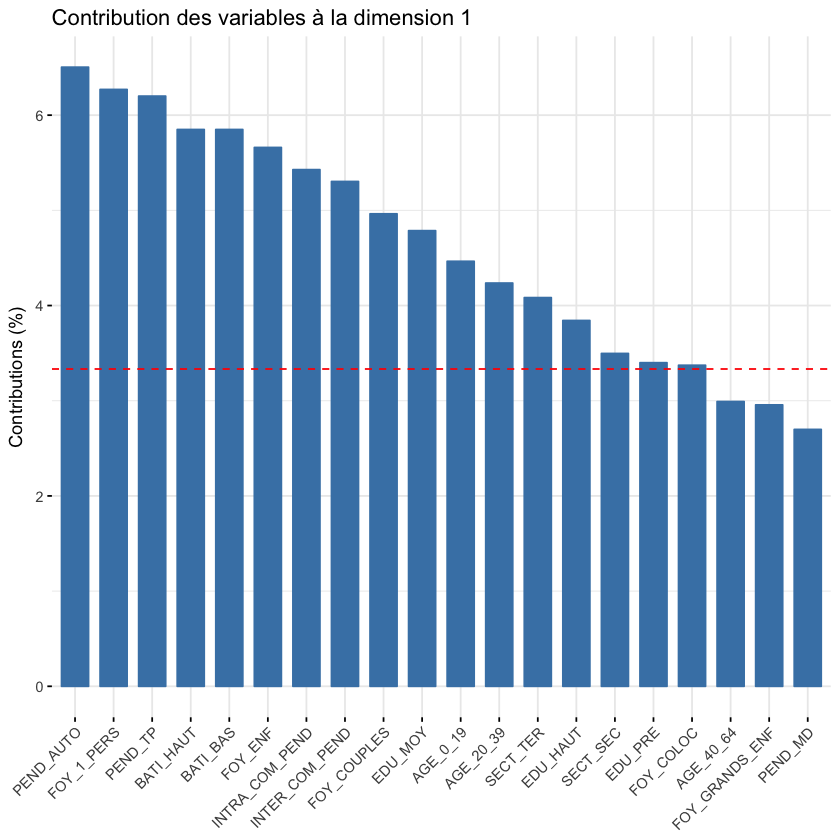

In [190]:
fviz_contrib(acp, choice="var", axes=1, top=20, title="Contribution des variables à la dimension 1")

### 3.3 Représentation simultanée des variables et individus

Il est possible aussi de visualiser à la fois les variables et les régions (individus) dans le même graphique, sous forme d'un **biplot**:

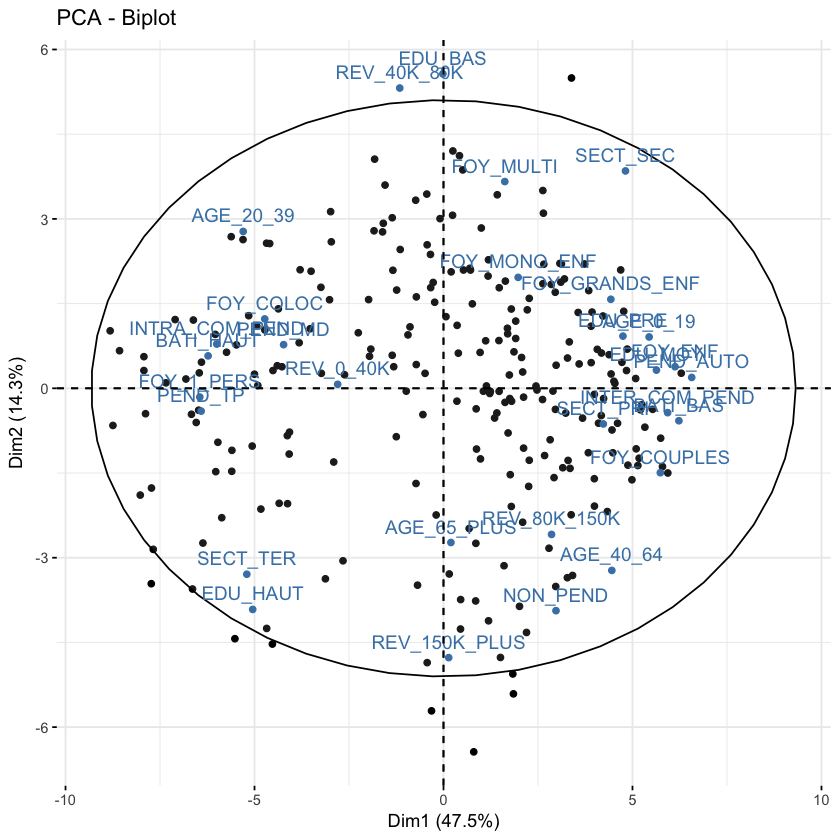

In [195]:
fviz_pca_biplot(
    acp,
    geom.ind="point",
    geom.var=c("point", "text"),
    addEllipses=TRUE
)

### 3.4 Élimination de variables

Si notre ACP n'est pas encore satisfaisante, nous pouvons tenter d'éliminer quelques variables initiales qui ne sont pas très liées aux premières dimensions, mais qui ont des corrélations essentiellement avec les dimensions supérieures.

Dans notre exemple, on pourrait p.ex. identifier les variables AGE_65_PLUS, REV_0_40K, FOY_MONO_ENF et potentiellement d'autres pour l'élimination. Quelques essais rapides permettent souvent d'augmenter sensiblement la part de variance expliquée par les 2-4 premières composantes.

### 3.5 Cartographie des composantes

Nous avons vu plus haut qu'il est possible de faire des **graphiques de type nuage de points** avec les scores factoriels. Ces graphiques peuvent être générés sous forme d'une carte en symboles proportionnels colorés en ajoutant une ou deux variables supplémentaires, p.ex. la population de la région pour la taille des symboles, et le district ou autre variable nominale pour la couleur des symboles.

Mais nous pouvons également faire une **carte choroplèthe avec les scores factoriels**, une carte par composante principale. Dans un tel cas, nous nous limitons typiquement à deux ou trois dimensions au maximum. La cartographie implique dans ce cas aussi **l'interprétation des composantes**.